In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import special, stats
import numpy as np
import seaborn as sns
from cycler import cycler
from patsy import bs, dmatrix
#from splines import splines

viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1843137254901961, 0.4196078431372549, 0.5568627450980392, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0),
            (0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 0.5),
            (0.1843137254901961, 0.4196078431372549, 0.5568627450980392, 0.5),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 0.5),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 0.5),
            (0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 0.3),
            (0.1843137254901961, 0.4196078431372549, 0.5568627450980392, 0.3),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 0.3),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 0.3)]

In [2]:
def splines(knots, x_true=None, y_true=None):
    # Get x-y values from true function
    if x_true is None:
        x_min, x_max = 0, 6
        x_true = np.linspace(x_min, x_max, 200)
    else:
        x_min, x_max = min(x_true), max(x_true)

    if y_true is None:
        y_true = np.sin(x_true)

    # Prepare figure
    _, axes = plt.subplots(2, 2, figsize=(9, 6),
                         constrained_layout=True,
                         sharex=True, sharey=True)
    axes = np.ravel(axes)

    # Plot the knots and true function
    for ax in axes:
        ax.vlines(knots, -1, 1, color='grey', ls='--')
        ax.plot(x_true, y_true, 'C4.', lw=4, alpha=0.5)
        ax.set_xticks([])
        ax.set_yticks([])

    labels = ["Piecewise Constant", "Piecewise Linear", "Piecewise Quadratic", "Piecewise Cubic"]
    for order, ax, label in zip(range(0, 4), axes, labels):
        B = basis(x_true, order, knots)
        y_hat = ols(B, y_true)
        ax.plot(x_true, y_hat, c='k')
        ax.set_title(label)

def basis(x_true, order, knots):
    """compute basis functions"""
    B = []
    for i in range(0, order+1):
        B.append(x_true**i)
    for k in knots:
        B.append(np.where(x_true < k, 0, (x_true - k) ** order))
    B = np.array(B).T
    return B


def ols(X, y):
    """Compute ordinary least squares in closed-form"""
    β = np.linalg.solve(X.T @ X, X.T @ y)
    return X @ β

2. (20) For the bike rental example we discussed in class on splines we used
a Gaussian distribution as the likelihood for counts. As we discussed
this distribution is continuous but is often used as an approximation for
discrete likelihoods if the values of the response variable are large. For
this problem use the subset of the bike rental data we used in class (see
cell 13 in the Spines notebook).
(a) Redo the regression but with a Poisson likelihood. Remember that
for this distribution you will need to constrain the priors and you
should not normalize the data. Show your results.
(b) Redo the regression but with a negative binomial likelihood. Show
your results
(c) Compare the results for each of this likelihoods with each other and
with the Gaussian results and discuss which one would be preferred
this bike rental problem.


In [3]:
from google.colab import files
uploaded = files.upload()

Saving algae.csv to algae.csv
Saving bikes_hour.csv to bikes_hour.csv


In [4]:
#specific spline data from class
data = pd.read_csv("bikes_hour.csv")
data.sort_values(by="hour", inplace=True)

# We standardize the response variable
data_cnt_om = data["count"].mean()
data_cnt_os = data["count"].std()
data["count_normalized"] = (data["count"] - data_cnt_om) / data_cnt_os
# Remove data, you may later try to refit the model to the whole data
data = data[::50]

 (a) Redo the regression but with a Poisson likelihood. Remember that for this distribution you will need to constrain the priors and you should not normalize the data. Show your results.

Text(0, 0.5, 'count_normalized')

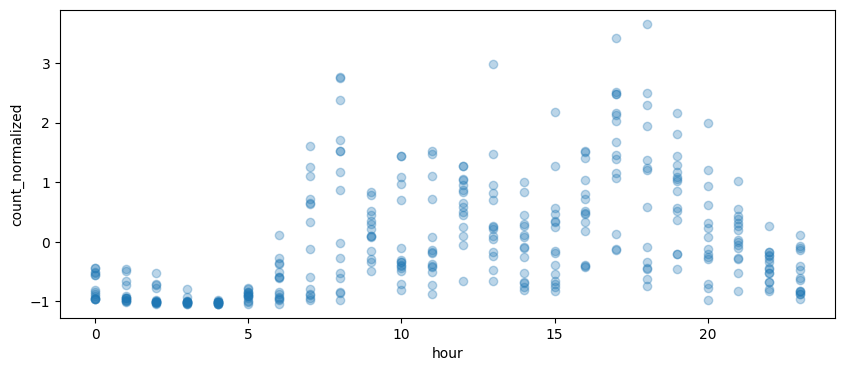

In [5]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(data.hour, data.count_normalized, "o", alpha=0.3)
ax.set_xlabel("hour")
ax.set_ylabel("count_normalized")

In [6]:
num_knots = 6
knot_list = np.linspace(0, 23, num_knots)[1:-1]
B = dmatrix(
    "bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
    {"cnt": data.hour.values, "knots": knot_list},
)

In [7]:
#creating the poisson model
with pm.Model() as poisson_model:
    τ = pm.HalfCauchy('τ', 1)
    β = pm.HalfNormal("β", sigma=τ, shape=B.shape[1])
    λ = pm.Deterministic("λ", pm.math.dot(np.asfortranarray(B), β))
    c = pm.Poisson("c", mu=λ, observed=data["count"].values)
    poisson_trace = pm.sample(1000, return_inferencedata=True)


In [8]:
# Regression Model with Negative Binomial likelihood
with pm.Model() as negbinom_model:
    τ = pm.HalfCauchy('τ', 1)
    β = pm.HalfNormal("β", sigma=τ, shape=B.shape[1])
    λ = pm.Deterministic("λ", (pm.math.dot(np.asfortranarray(B), β)))
    α = pm.HalfNormal("α", sigma = 1)
    c = pm.NegativeBinomial("c", mu=λ, alpha=α, observed=data["count"].values)
    negbinom_trace = pm.sample(1000, return_inferencedata=True)

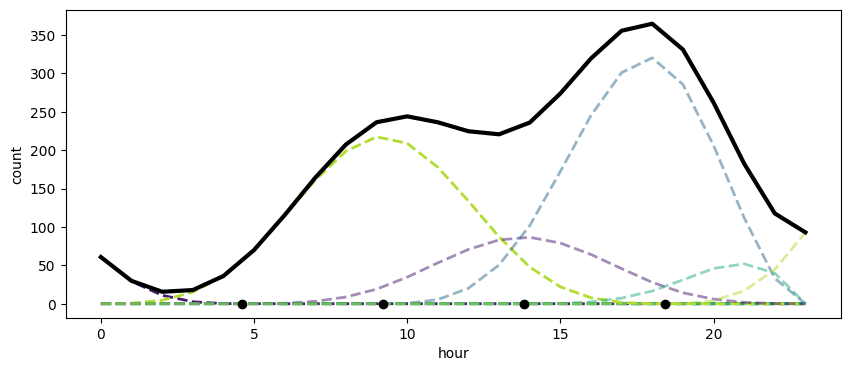

In [9]:
#for poisson
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_prop_cycle(cycler('color', viridish))
posterior = poisson_trace.posterior.stack(samples=['chain', 'draw'])
ax.plot(data.hour, (B*posterior["β"].mean("samples").values), lw=2, ls='--')
ax.plot(data.hour, posterior["λ"].mean("samples"), 'k', lw=3)
ax.set_xlabel("hour")
ax.set_ylabel("count")
ax.plot(knot_list, np.zeros_like(knot_list), 'ko')

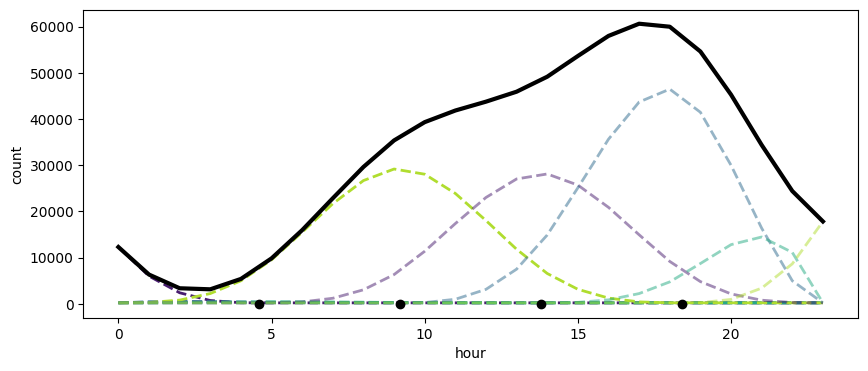

In [10]:
#For negative binomial
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_prop_cycle(cycler('color', viridish))
posterior = negbinom_trace.posterior.stack(samples=['chain', 'draw'])
ax.plot(data.hour, (B*posterior["β"].mean("samples").values * data_cnt_os) + data_cnt_om, lw=2, ls='--')
ax.plot(data.hour, posterior["λ"].mean("samples") * data_cnt_os + data_cnt_om, 'k', lw=3)
ax.set_xlabel("hour")
ax.set_ylabel("count")
ax.plot(knot_list, np.zeros_like(knot_list), 'ko')

array([[<Axes: title={'center': 'β\n0'}>,
        <Axes: title={'center': 'β\n1'}>,
        <Axes: title={'center': 'β\n2'}>,
        <Axes: title={'center': 'β\n3'}>],
       [<Axes: title={'center': 'β\n4'}>,
        <Axes: title={'center': 'β\n5'}>,
        <Axes: title={'center': 'β\n6'}>,
        <Axes: title={'center': 'β\n7'}>]], dtype=object)

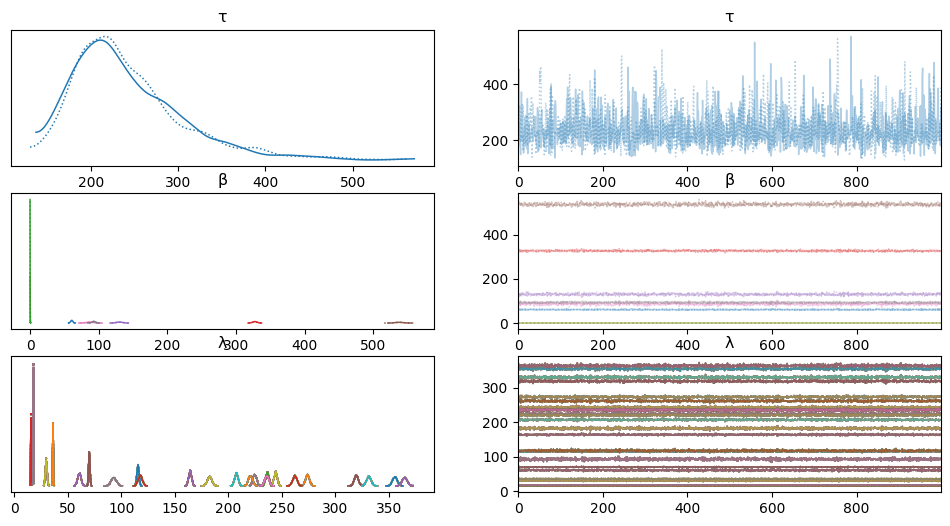

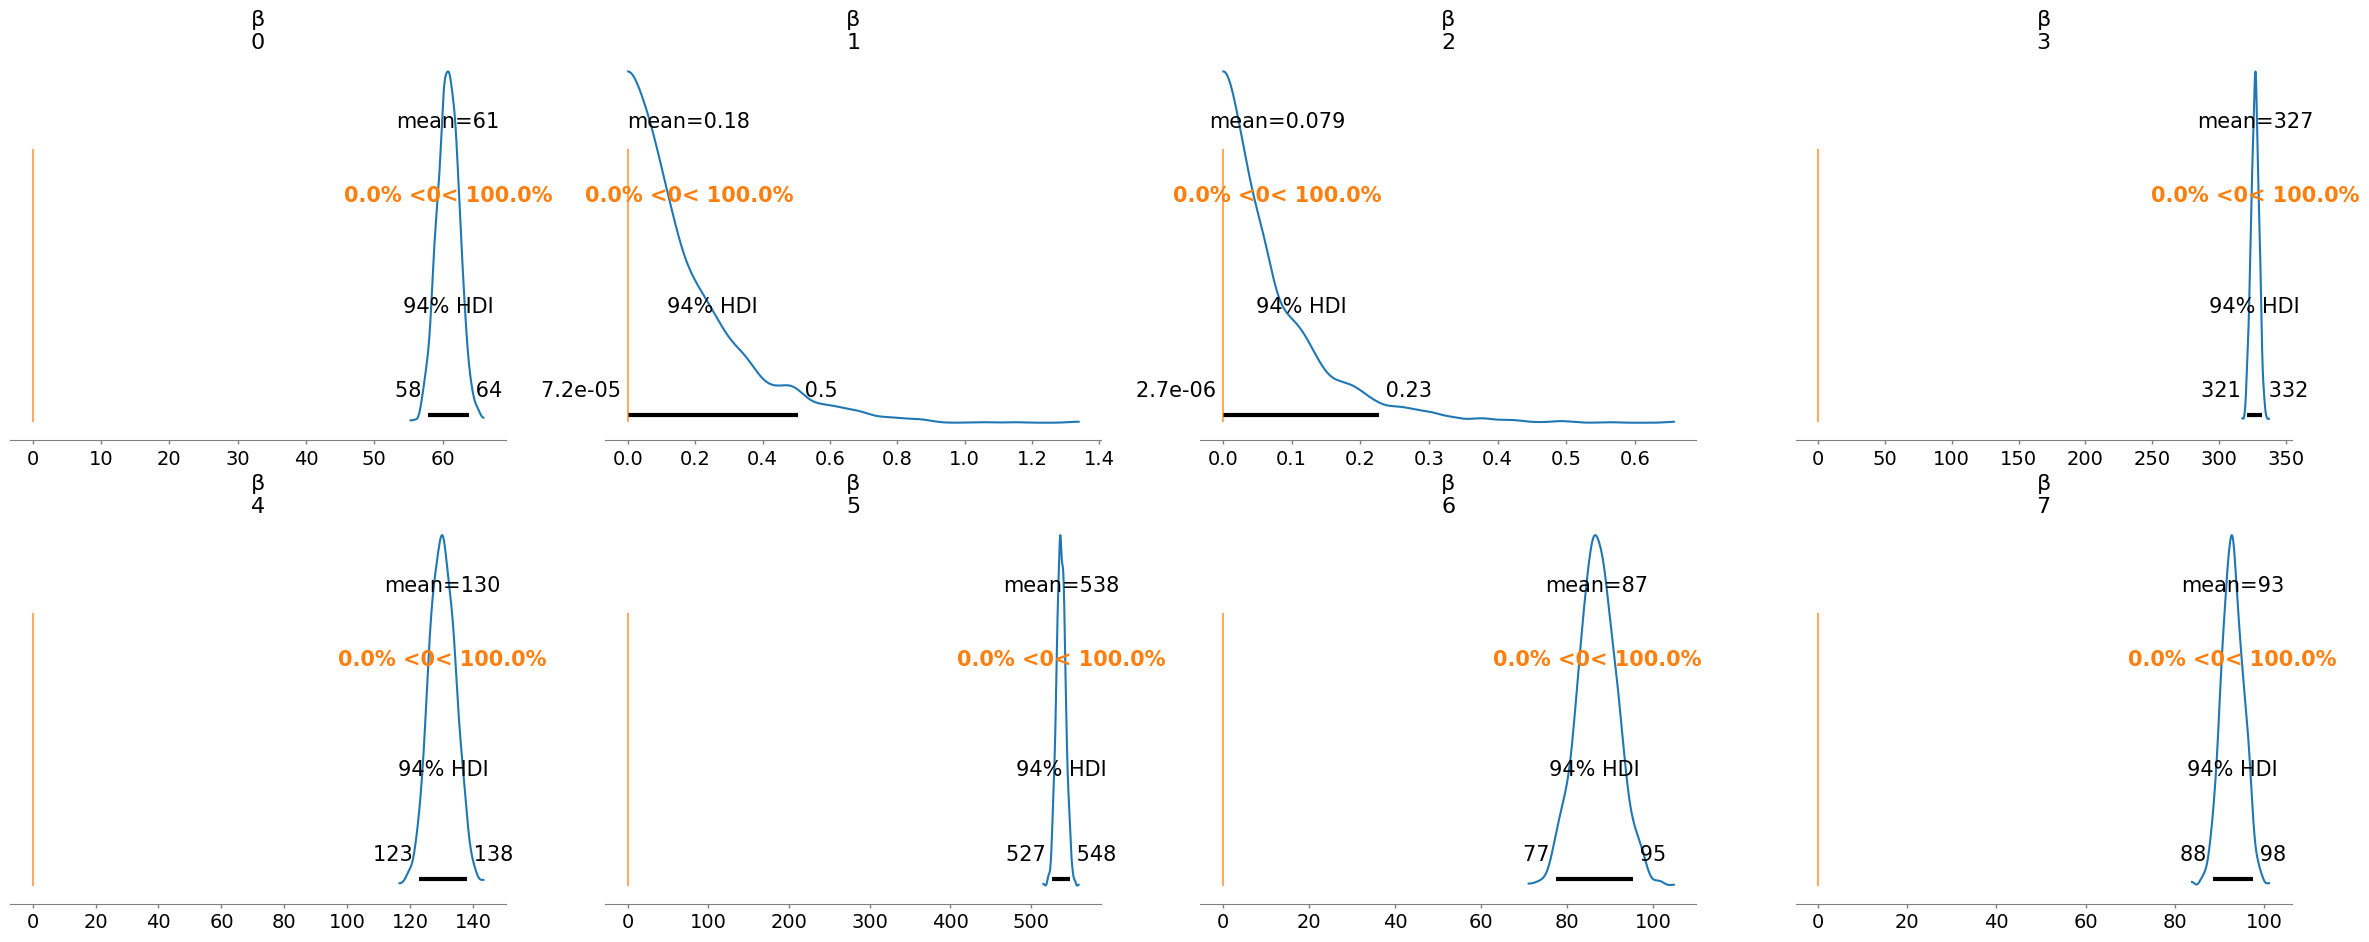

In [14]:
az.plot_trace(poisson_trace)
az.plot_posterior(poisson_trace, var_names=['β'], ref_val = 0)

array([[<Axes: title={'center': 'β\n0'}>,
        <Axes: title={'center': 'β\n1'}>,
        <Axes: title={'center': 'β\n2'}>,
        <Axes: title={'center': 'β\n3'}>],
       [<Axes: title={'center': 'β\n4'}>,
        <Axes: title={'center': 'β\n5'}>,
        <Axes: title={'center': 'β\n6'}>,
        <Axes: title={'center': 'β\n7'}>]], dtype=object)

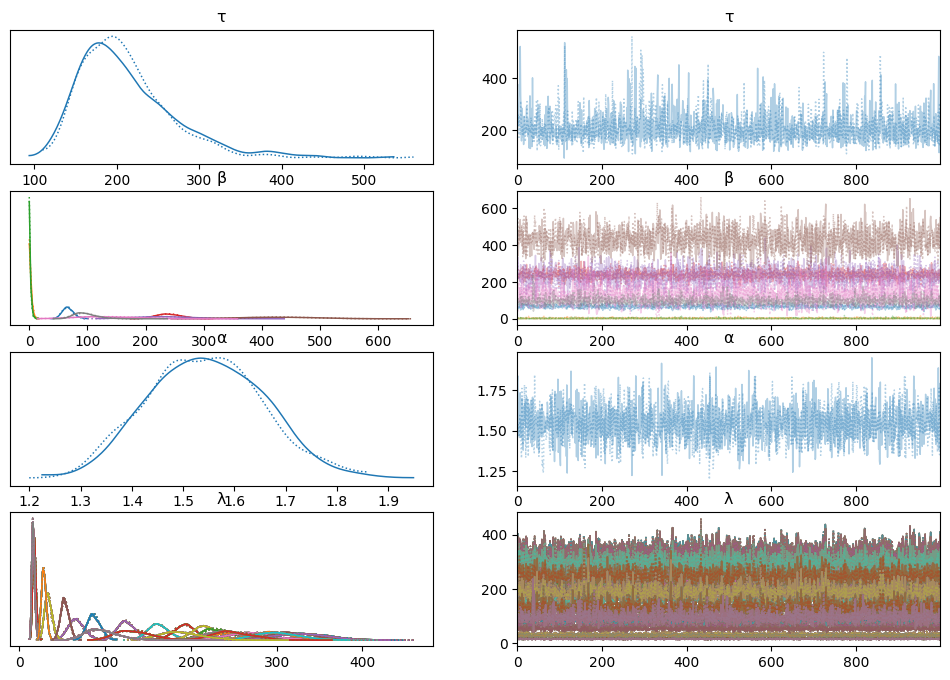

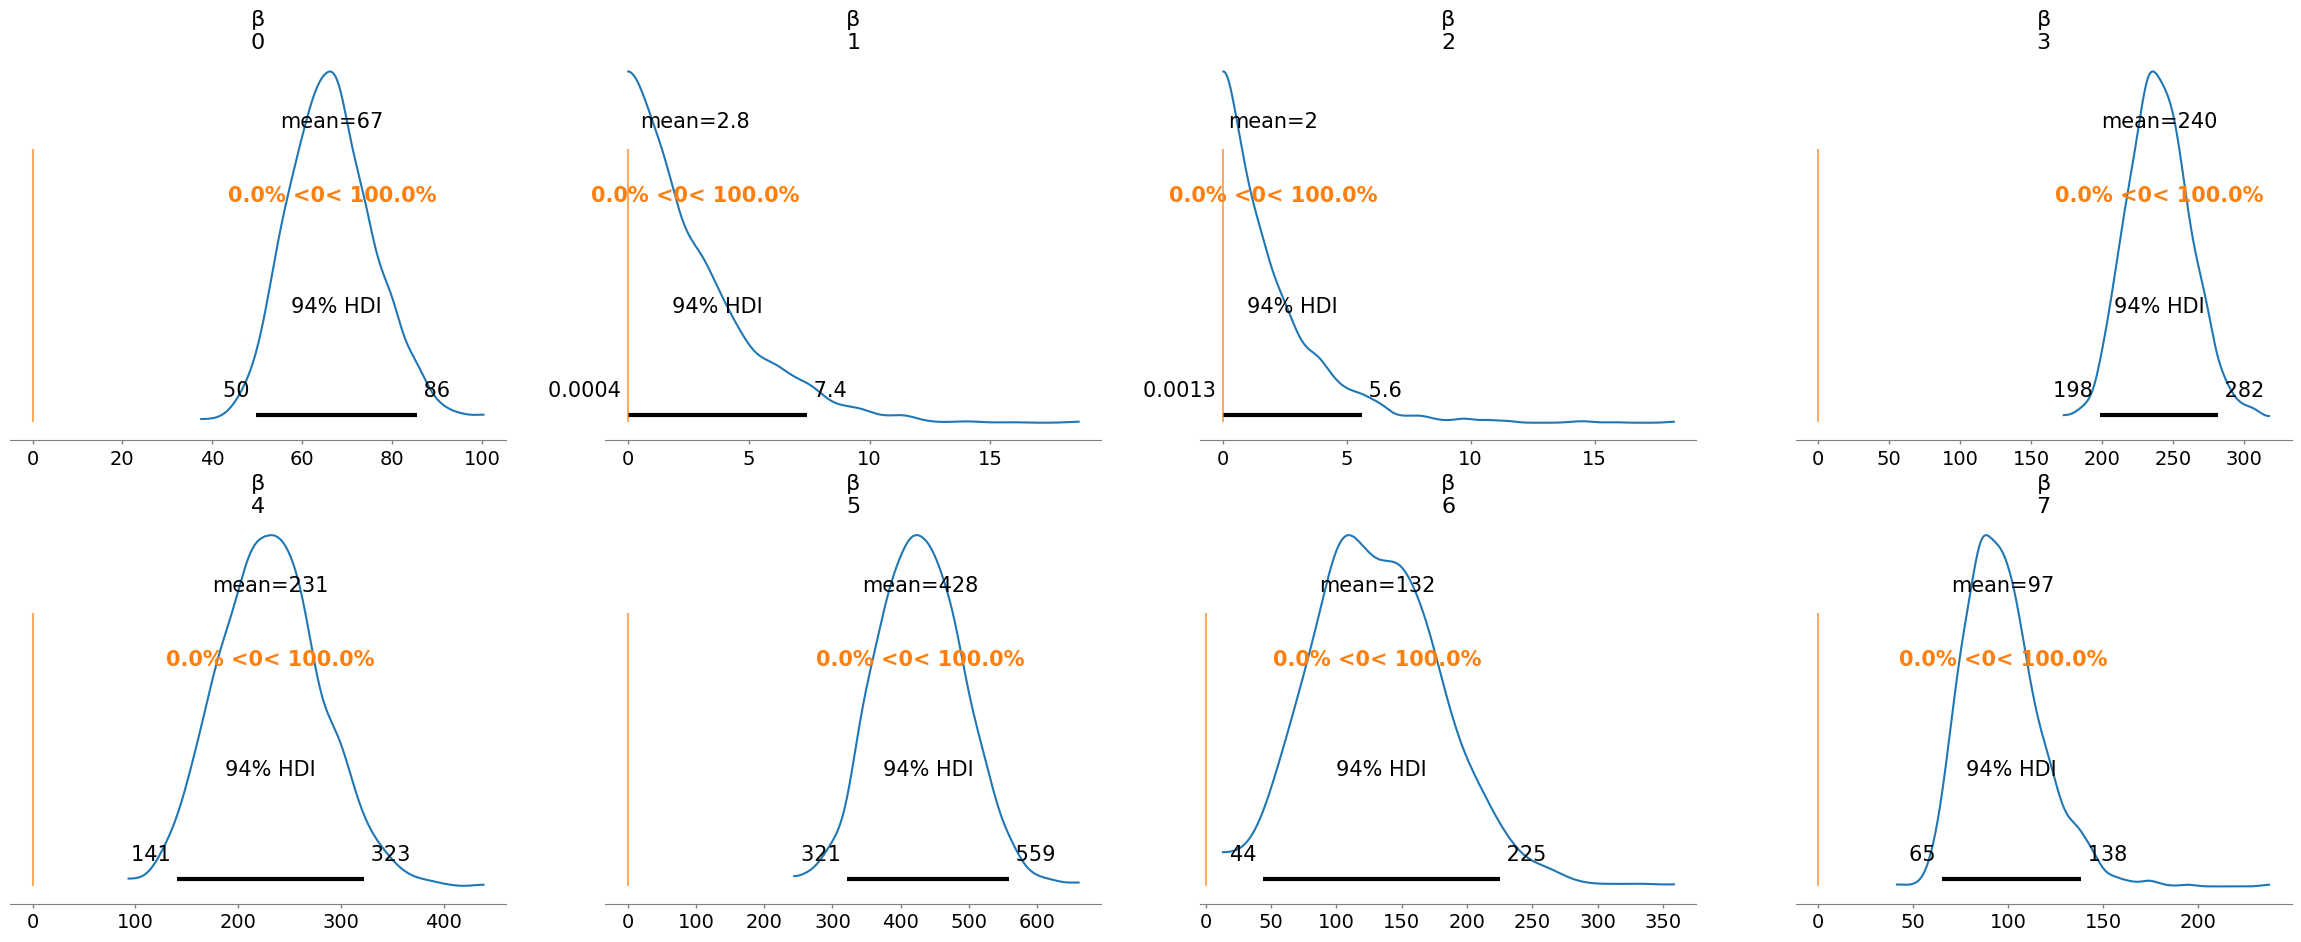

In [15]:
az.plot_trace(negbinom_trace)
az.plot_posterior(negbinom_trace, var_names=['β'], ref_val = 0)

(c) Compare the results for each of this likelihoods with each other and
with the Gaussian results and discuss which one would be preferred
this bike rental problem.

Based on the plots produced for each predictive model, the negative binomial seems to do a better overall job of fitting the data. For example, the plots of predicted bike rentals shows a better fit to the peak data points, with the predictive uncertainty (dashed lines) more closely encompassing the observed data. This suggests the Negative Binomial model is accounting for overdispersion in the data more effectively. On the other hand, you could make the case that the Poisson model has a tighter distribution of parameter estimates based on the trace plots, but I think using the predicted bike rentals as an estimate is a better way to compare the models overall.

